# Weak Coupling ME for $\sigma_z$ coupling

$H_0+H_{I,s}=\omega_e\sum_{i=1}^{N}\sigma_i^+\sigma_i^-+h\sum_{i=1}^{N-1}\left(\sigma_i^+\sigma_{i+1}^-+\sigma_{i+1}^+\sigma_{i}^-\right)+\sigma_1^z\otimes B1+\sigma_N^z\otimes B2$

In [1]:
#Initialization
from numpy import (array, nonzero, zeros, exp, all, 
                   sqrt, inf, cosh, sinh, real, imag, linspace) 
from scipy.linalg import expm
from scipy.integrate import quad
from math import pi
from qutip import (sigmap, qeye, tensor, sigmaz, Qobj, liouvillian, 
                  operator_to_vector, vector_to_operator)
#%matplotlib inline
import matplotlib.pyplot as plt

##Rate function
#This function computes the rates for the the coupling to a 
#bosonic heat bath of temperature $T$. A superohmic (QD) 
#spectral density is assumed. If this is changed one has to 
#add a limit term to the zero energy rate calculation.
def J(v, A, wc):
    return A*v**(3)*exp(-v**2/wc**2)

def beta(T):
    return 7.6087/T
def coth(x):
    return cosh(x)/sinh(x)
def integrandpos1(v,w,T,A,wc):
    return -J(v,A,wc)*(coth( beta(T) * v/2 )+ 1)/(v+w)

#divergent part for w positive
def integrandpos2(v,w,T,A,wc):
    return J(v,A,wc)*(coth( beta(T) * v/2 )- 1)


def integrandneg1(v,w,T,A,wc):
    return J(v,A,wc) * (coth( beta(T) * v/2 )- 1)/(v+abs(w))

#divergent part for w negative
def integrandneg2(v,w,T,A,wc):
    return -J(v,A,wc) * (coth( beta(T) * v/2 )+ 1)

def C(T, w, A, wc):
    if w > 0:
        return (pi *2 * J(w,A,wc) * ( coth(beta(T) * w/2 ) - 1 ) 
                + 0.5 * 1j * (quad(integrandpos1,0,50,args=(w,T,A,wc))[0]
                              + quad(integrandpos2,0.000001,50, weight ='cauchy',wvar=w,epsabs=1e-20,args=(w,T,A,wc))[0]))
    elif w == 0:
        return -1j*quad(lambda x: J(x, A, wc)/x,0,50)[0]
    elif w < 0:
        return (pi*2 * J(abs(w),A,wc) * ( coth(0.5 * beta(T) * abs(w)) + 1 ) 
                + 1 / 2 * 1j * (quad(integrandneg1,0,50,args=(w,T,A,wc))[0]
                                + quad(integrandneg2,0.000001,50, weight ='cauchy',wvar=abs(w),epsabs=1e-20,args=(w,T,A,wc))[0]))
    
##Function creating matrix representaion of system Hamiltonian
def H(N,we,h):
    sp = sigmap()
    sm = sigmap().dag()
    iD = qeye(2)
    Ex = sp*sm
    sz = sigmaz()

    Ex_list = []
    sp_list = []
    sm_list = []
    sz_list = []
    
    #Build the three different operators for each site
    for i in range(N):
        op_list = []
        for j in range(N):
            op_list.append(iD)
        
        op_list[i] = Ex
        Ex_list.append(tensor(op_list))
        
        op_list[i] = sp
        sp_list.append(tensor(op_list))
        
        op_list[i] = sm
        sm_list.append(tensor(op_list))
        
        op_list[i] = sz
        sz_list.append(tensor(op_list))
    
    #Build the system Hamiltonian
    H0=0
    
    #rotating terms
    for i in range(N):
        H0 += we * Ex_list[i]
    
    #interaction terms
    for i in range(N-1):
        H0 += h * (sp_list[i] * sm_list[i+1] 
                  + sp_list[i+1] * sm_list[i])
    return [H0, sz_list, sm_list]

#interaction operators in H_0 basis
def Int(Op1,OpN, H0, N):
    #Basis transformation to transform into H_0 eigenbasis
    U0bas = []
    for i in range(2**N):
        U0bas.append(H0.eigenstates()[1][i])
    
    #write Op1 and OpN in H_0 basis
    a1 = Op1.transform(U0bas)
    aN = OpN.transform(U0bas)
    
    #non-zero elements
    IntElem1 = nonzero(a1.full())
    IntElemN = nonzero(aN.full())
    Count1 = IntElem1[0].size
    CountN = IntElemN[0].size
    
    #list storing the different different operators
    A1 = []
    AN = []
    
    #Adding the appropriate operators as Qobj
    for i in range(Count1):
        temp = zeros([2**N,2**N])+1j*zeros([2**N,2**N])
        temp[IntElem1[0][i]][IntElem1[1][i]]=a1.full()[IntElem1][i]
        A1.append(Qobj(temp))
        
    for i in range(CountN):
        temp = zeros([2**N,2**N])+1j*zeros([2**N,2**N])
        temp[IntElemN[0][i]][IntElemN[1][i]]=aN.full()[IntElemN][i]
        AN.append(Qobj(temp))
    
    #non-zero energies
    Omega1 = []
    OmegaN = []
    for i in range(Count1):
        Omega1.append(H0.eigenenergies()[IntElem1[1][i]]
                     -H0.eigenenergies()[IntElem1[0][i]])
        
    for i in range(CountN):
        OmegaN.append(H0.eigenenergies()[IntElemN[1][i]]
                     -H0.eigenenergies()[IntElemN[0][i]])
    
    return [[Omega1,A1],[OmegaN,AN]]

#Function to find the right collapse operators for the Master Eq.
def Collapse(Op1,OpN,H0,N, A, wc, T1, TN):
    IntOp = Int(Op1,OpN, H0, N)
    Colap1 = []
    ColapN = []
    for i in range(len(IntOp[0][0])):
        C1 = (sqrt(2*C(T1,IntOp[0][0][i],A,wc).real)
                       *IntOp[0][1][i]).tidyup()
        if all(C1.full()==0):
            C1 = 0
        else:
            Colap1.append(C1)
    
    for i in range(len(IntOp[1][0])):
        CN = (sqrt(2*C(TN,IntOp[1][0][i],A,wc).real)
                       *IntOp[1][1][i]).tidyup()
        if all(CN.full()==0):
            CN = 0
        else:
            ColapN.append(CN)
    
    return [Colap1, ColapN]

#Function to find Lamb-shift operators
def HLS(Op1, OpN, H0, N, A, wc, T1, TN):
    IntOp = Int(Op1, OpN, H0, N)
    HLS1 = 0
    HLSN = 0
    for i in range(len(IntOp[0][0])):
        HLS1 += (C(T1,IntOp[0][0][i],A,wc).imag 
                 * IntOp[0][1][i].dag() * IntOp[0][1][i]).tidyup()
    
    for i in range(len(IntOp[1][0])):
        HLSN += (C(TN,IntOp[1][0][i],A,wc).imag 
                 * IntOp[1][1][i].dag() * IntOp[1][1][i]).tidyup()
    return [HLS1,HLSN]

#Function to find the reduced density matrix for a specific time
def rho(t, L, rhoi):
    return vector_to_operator((t*L).expm()*operator_to_vector(rhoi))

### Interaction Operators

This function takes the two system operators interacting with the two environments and outputs the nonzero elements in the $H_0$ basis: $\big< E\big\vert \mathcal{O} \big\vert E'\big> \big\vert E\big>\big<E'\big\vert$ together with the corresponding energy differences $\omega=E'-E$

### Weak Coupling Master Equation 

First the list of collapse operators are build. These consist of the interaction operators multiplied by the $\sqrt{2 C (\omega)}$, where $C$ is the real part of the fourier transformed rates. 

Next the lamb shift operators are found. The value is given by the imaginary part of the rate and the system operator is $A^\dagger(\omega) A(\omega)$

The liouvillian superoperator can now be found

In [52]:
#Parameters
N = 2
we = 1
h = 0.5
T1 = 10
TN = 10
A = 0.02
wc = 2.2

#Relevant operators
H0 = H(N,we,h)[0]
Sm =  H(N,we,h)[2]
Sz = H(N,we,h)[1]
Oi1 = Sm[0].dag()*Sm[0]#H(N,we,h)[1][0]
OiN = Sm[N-1].dag()*Sm[N-1]#Qobj(zeros([2**N,2**N]))#H(N,we,h)[1][N-1]
Lamb = HLS(Oi1, OiN, H0, N, A, wc, T1, TN)
Collap = Collapse(Oi1, OiN, H0, N, A, wc, T1, TN)
#Liouvillian
L = liouvillian(Qobj((Fl(H0)).full()),Collap[0])

#remove underlying Hilbert space structure information from Qobj
def Fl(A):
    return Qobj(A.full())

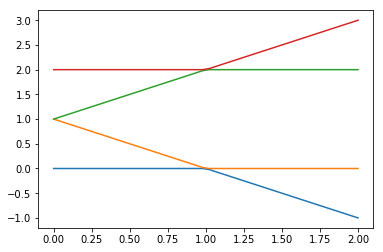

In [53]:
hlist = linspace(0,2)
eigs = []
for count in range(len(hlist)):
    h0 = H(N,we,hlist[count])[0]
    eigs.append(h0.eigenenergies())
plt.plot(hlist,eigs)
plt.show()

### Dynamics

Choosing an initial state of the system, one can now compute the dynamics of the reduced system

In [54]:
rhoi = Sm[0].dag()*Sm[0]*Sm[1]*Sm[1].dag()

time = []
tN = 50
dt = 0.6
state = []
Occu = []
for i in range(N):
    Occu.append([])
    
for i in range(tN):
    state.append(rho(i*dt,L,Fl(rhoi)))
    time.append(dt*i)
    for j in range(N):
        Occu[j].append((state[i]*Qobj((Sm[j].dag()*Sm[j]).full())).tr().real)
    

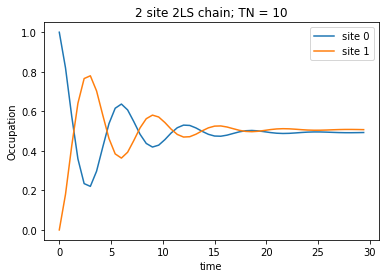

In [55]:
fig1 = plt.figure(1)
for j in range(N):
    plt.plot(time, Occu[j], label='site '+str(j))

plt.xlabel('time')
plt.ylabel('Occupation')

plt.title(str(N) + " site 2LS chain; TN = "+str(TN))

plt.legend()

plt.show()

The collapse operators for the two different baths only differ by a sign, otherwise they are equal in form and absolute value. Notice that as the rates are real so are the collapse operators. As collapse operators always appear in pairs of two the sign doesn't make any difference. This means that from a master equation POV the two baths act in a similar fashion on the chain eigenstates. 